# Stream sim galpy

This notebook is meant to simulate stellar streams formed through star cluster accretion in a host potential (commonly the milky way MW).
It requires a config files, found in config folder, with particular cluster data (Pal_5 config fle is given as an example). User can create his own sts config file from the custom_config file in the same directory.
It is paired with simulation/data analysis python files found in Codes directory.
It switches beetween ICRS, galactic and (phi1, phi2) coordinate systems, depending of the user specification.

Required libraries to make it work are specified in the README file.

# Initialization

Import useful libraries and utilities, cluster_config file

In [80]:
###Libraries
#Mains
# %matplotlib widget
%matplotlib inline
import galpy.potential as gp
import galpy.df as gd #for streams PDF generation
import galpy.actionAngle as ga
from galpy.orbit import Orbit

#Utils
from importlib import reload
import pandas as pd
import sys
import yaml
import os
#Define user path
sys.path.append(os.path.abspath('../'))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import astropy.units as u
import astropy.coordinates as ac
from astropy.table import Table
# import galpy.util.conversion as guconv
import galpy.util.coords as gucoord
import galpy.util.conversion as guconv
import gala.coordinates as gc #for great circle rotation
with ac.galactocentric_frame_defaults.set("v4.0"):
    galcen_frame = ac.Galactocentric()
import stream_galsim.stream_utils as sutils; reload(sutils) #custom .py file with utilities

<module 'stream_galsim.stream_utils' from '/home/hallouin/Documents/thall_2025/Streams/stream_sim/stream_galsim/stream_utils.py'>

In [52]:
##Load progenitor config file
# Path to the yaml config file in the 'config' folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
config_file = 'galstreams_Pal5_config.yaml'
config_path = os.path.join(base_dir, 'config', config_file)

# Load YAML and convert it to a DataFrame
with open(config_path, 'r') as file:
    config_data = yaml.safe_load(file)

##Display cluster data
#current pose/velocity in ICRS
stream_data = pd.DataFrame(config_data)
# print(stream_data)
#only progenitor data is wanted for our simulation
progenitor = stream_data[4:].loc[:,["cluster","ra","dec","distance","pm_ra_cosdec","pm_dec","radial_velocity"]]
#["dec","dec_unit","distance","distance_unit","frame","pm_dec","pm_dec_unit","pm_ra_cosdec","pm_ra_cosdec_unit", "ra","ra_unit","radial_velocity","radial_velocity_unit"]
print(progenitor.values.tolist()[0])

['Pal5', 229.0, -0.124, 22.9, -2.296, -2.257, -58.7]



# Data generation with stellar stream simulation

The first objective is to generate stellar flux data using a simulation.
The user must choose between a mock flux simulation and an N-body flux simulation.

The mock flux simulation uses the particle spray technique with galpy/gala: it generates n stars outside the progenitor at each time step dt, initially requiring only the progenitor's orbit as input in phase space. It is faster, but provides a simplified model of the flux, providing only the main stars.

The N-body simulation simulates the complete development of the flux, treating each star as a massless body initially within the progenitor, and decaying it under tidal effects.

"Mock" stream using galpy library.

**Step 1: System initialisation.**

The system includes initially a progenitor, an accreting host, a perturbating DM subhalo (optional), and a cluster host like dwarf galaxies (optional)

In [3]:
##Progenitor
cluster = progenitor.values.tolist()[0][0]
prog_orbit = Orbit(progenitor.values.tolist()[0][1:], radec=True) #progenitor orbit instance. radec=True specify the frame used radec=ICRS

##Pal5
prog_mass = 2*10.**4.*u.Msun
prog_a = 23.*u.pc #scale radius of the plummer sphere
rc = 23*u.pc #progenitor radius
prog_pot = gp.PlummerPotential(prog_mass, prog_a)#Define progenitor with a plummer potential
# prog_sigv = sutils.Plummer_sigv(prog_mass, prog_a, rc)
prog_sigv = 0.365*u.km/u.s #velocity dispersion in original cluster. It's assumed that the velocity distribution is isotropic
t_disrupt = 4.5*u.Gyr #time of disruption of cluster, typically 4.5Gyr
# tdisrupt= guc.time_in_Gyr(V0,R0)

###Accreting host
### Usually Milky way potential
V0, R0= 245.6, 8.122 #scale parameters
vsun=[-12.9,245.6,7.78] #for streamdf, vxyz
mw_pot = gp.MWPotential2014
#mw_pot = gp.LogarithmicHaloPotential(normalize=1.,q=0.9) #is also often used


###Dark matter subhalo(s) and impact parameters
halo_mass = 1e5 *u.Msun #halo mass
halo_a =0.01*u.kpc
halo_pot = gp.NFWPotential(amp=halo_mass, a=halo_a)
v_halo = np.array([6.82200571,132.7700529,149.4174464]) #in km/s (vx,vy,vz)

b_impact = 0.#1 * u.pc
t_impact = 1* u.Gyr
angle_impact= 0.5
###DG, initially hosting the cluster. Optional

In [4]:
### Action angle setup - for action-angle space
aaisochrone = ga.actionAngleIsochroneApprox(pot=mw_pot,b=1.5)

**Step 2: Stream pdf generation**

In [5]:
###Modelise Non-perturbed stream and perturbed stream using streamdf
#we use full_galpydf from sutils to get the complete pdf (trail + lead + perturbed) in a single run

s_lead, s_trail, s_perturbed = sutils.full_galpy_df(
                        sigv=prog_sigv, #Radial velocity dispersion of the progenitor
                        progenitor=prog_orbit, #Progenitor orbit instance
                        pot = mw_pot, #accreting host potential
                        aA = aaisochrone, #ActionAngle instance used to convert (x,v) to actions. Generally a actionAngleIsochroneApprox instance.                        vsun=vsun,
                        ro = R0, #Distance scale for translation into internal units
                        vo = V0, #Velocity scale for translation into internal units
                        vsun = vsun,                         
                        tdisrupt = t_disrupt,#  Time since start of disruption
                        perturbed = True, #Including or a DMS perturbation
                        timpact = t_impact, # Time of impact
                        impactb = b_impact, #Impact parameter between halo and streams
                        subhalovel = v_halo, # Velocity of the subhalo
                        subhalopot = halo_pot,# Gravitational potential of the subhalo
                        impact_angle = angle_impact, #Angle offset from progenitor at which the impact occurred
                        )

/home/hallouin/miniconda3/envs/streams/lib/python3.13/site-packages/galpy/df/streamgapdf.py:1554: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  integrate.quad(_a_integrand, -1.0, 1.0, args=(y, b, w, pot, i))[0]



**Step 3: Sampling from stream pdf**

In [101]:
#lead, trail, lead+trail, perturbed arm, perturbed arm+other arm
s_lead_stars, s_trail_stars, s_full_stars, ps_stars, ps_full_stars = sutils.full_galpy_sampling(n_stars=50000, 
                                                                    s_lead=s_lead, s_trail=s_trail, s_perturbed=s_perturbed,
                                                                    ro=R0, vo=V0, perturbed = 'not', rdseed = 4)
#if you don't want to sample the perturbed part, set perturbed = 'not'


In [102]:
x_s, y_s ,z_s, vx_s, vy_s , vz_s = s_full_stars
# x_ps, y_ps ,z_ps, vx_ps, vy_ps , vz_ps = ps_full_stars

**Step 4: conversion into observer coordinate system and plot**

In simulation as in data analysis, the main goal of the study is to compute the star density variation along the stream. Hence we need to convert star positions in an appropriate and more physical frame. We'll use icrs then (Phi1,Phi2) coordinate system, where phi1 is the angle along the stream (longitude-like) and Phi2 the angle perpendicular to the stream (latitude-like), as seen from Earth. We define (0,0) as the progenitor position in the sky.

In [103]:
#smooth
s_stars_icrs = sutils.xyz_to_icrs(s_full_stars, velocities=True)
ra_s, dec_s, dist_s, pmra_s, pmdec_s, pmr_s = (s_stars_icrs.T.ra, s_stars_icrs.T.dec, s_stars_icrs.T.distance,
                             s_stars_icrs.T.pm_ra_cosdec, s_stars_icrs.T.pm_dec, s_stars_icrs.T.radial_velocity)

#perturbed
# ps_stars_icrs = sutils.xyz_to_icrs(ps_full_stars,  velocities=True)
# ra_ps, dec_ps, dist_ps, pmra_ps, pmdec_ps, pmr_ps = (ps_stars_icrs.T.ra, ps_stars_icrs.T.dec, ps_stars_icrs.T.distance,
#                              ps_stars_icrs.T.pm_ra_cosdec, ps_stars_icrs.T.pm_dec, ps_stars_icrs.T.radial_velocity)
# s_stars_icrs

Text(0, 0.5, 'Y (kpc)')

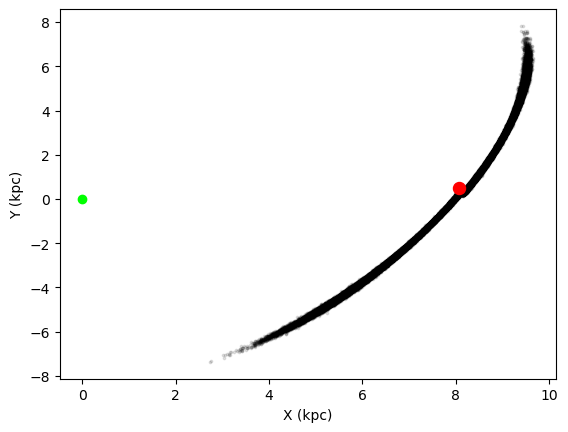

In [104]:
#3D representation
#Cluster, local background potential
#Pal5
c = ac.ICRS(ra=230 * u.deg, dec=-0.123 * u.deg,
               distance=22.9 * u.kpc,
               pm_ra_cosdec=-2.296 * u.mas/u.yr,
               pm_dec=-2.257 * u.mas/u.yr,
               radial_velocity=-58.7 * u.km/u.s)
               
c_gc = c.transform_to(galcen_frame)
fig2 = plt.figure()
ax2 = fig2.add_subplot()

ax2.scatter(-x_s, y_s, alpha=0.1, s=3, c='k')#sts
ax2.scatter(c_gc.cartesian.x,c_gc.cartesian.y,s=75, c='r')#progenitor
ax2.scatter(0,0, c='lime')#galatic center

ax2.set_xlabel('X (kpc)')
ax2.set_ylabel('Y (kpc)')
# ax2.set_zlabel('Z')

-2.296


Text(0.5, 0, 'Z (kpc)')

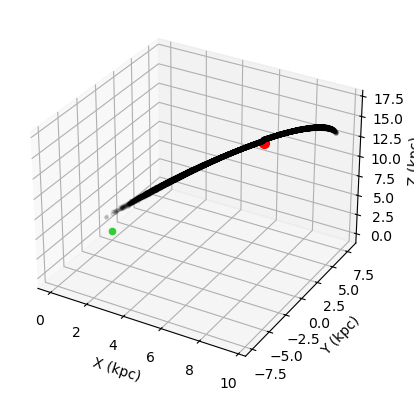

In [105]:
#3D representation
#Cluster, local background potential
# %matplotlib widget
print(c.pm_ra_cosdec.to_value(u.mas/u.yr))
fig3 = plt.figure()
ax3 = fig3.add_subplot(projection='3d')

ax3.scatter(-x_s, y_s ,z_s, alpha=0.1,s=5, c='k')#sts
ax3.scatter(c_gc.cartesian.x,c_gc.cartesian.y, c_gc.cartesian.z,s=50, c='r')#progenitor
ax3.scatter(0,0,0, c='limegreen')#galatic center

ax3.set_xlabel('X (kpc)')
ax3.set_ylabel('Y (kpc)')
ax3.set_zlabel('Z (kpc)')

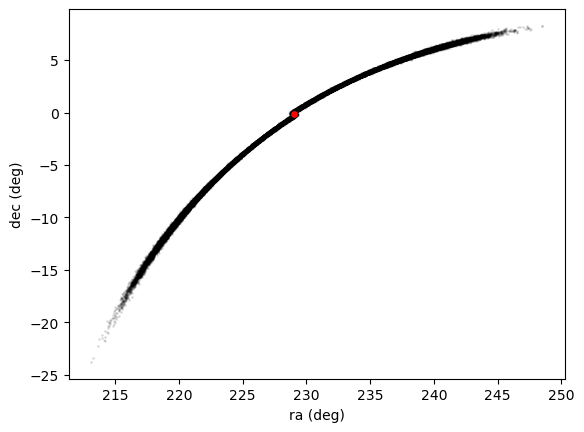

In [106]:
### plot the track in the radec frame to see how it would appears from an observer on earth
ra_prog, dec_prog = progenitor.loc[:,['ra']].values.tolist()[0], progenitor.loc[:,['dec']].values.tolist()[0]
# ra_prog, dec_prog = radec_prog
plt.figure()
# plt.scatter(ra_ps, dec_ps, s=0.5, c='purple')
plt.scatter(ra_s, dec_s, s=1, c='k', alpha=0.1)
plt.scatter(ra_prog, dec_prog, s=15, c='r')#progenitor

plt.xlabel("ra (deg)")
plt.ylabel("dec (deg)")
# plt.title("Stellar Stream (ICRS)")
plt.show()

In [107]:
### finally convert into Phi1,Phi2 frame
##this is a little bit tricky, since we cant the coordinate Phi1=0 follow the track, here we have 2 options:
# - Phi1=0 exactly follow the progenitor orbit. It means that we need to define a curviline abciss defined by the progenitor orbit
# - Phi1=0 is defined by the line which have the best fit with stellar streams stars, passing by the progenitor pos
#we choose for the moment option 2  

pole1 = ac.SkyCoord(ra=ra_prog*u.deg, dec=dec_prog*u.deg)
pole2 = ac.SkyCoord(ra=243.69*u.deg, dec=7.11*u.deg)

s_stars_phi12 = sutils.icrs_to_phi12(s_stars_icrs, pole1, pole2, velocities=True) 
phi1_s, phi2_s, dist_s, pm_phi1_s, pm_phi2_s, pmr_s = (s_stars_phi12.phi1, s_stars_phi12.phi2, s_stars_phi12.distance,
                                            s_stars_phi12.pm_phi1_cosphi2, s_stars_phi12.pm_phi2, s_stars_phi12.radial_velocity)

In [108]:
### Plot difference between perturbed and non perturbed vs non-perturbed

# plt.figure(figsize=(8, 4))
# plt.plot(ra_s, ra_ps-ra_s, 'x')
# plt.xlabel(r'$angle $ (°)')
# plt.ylabel(r'$\Delta$ (°)')
# plt.title(r'Position difference in angle of stars along stream track')
# plt.grid(True)
# plt.legend()
# plt.tight_layout()
# plt.show()

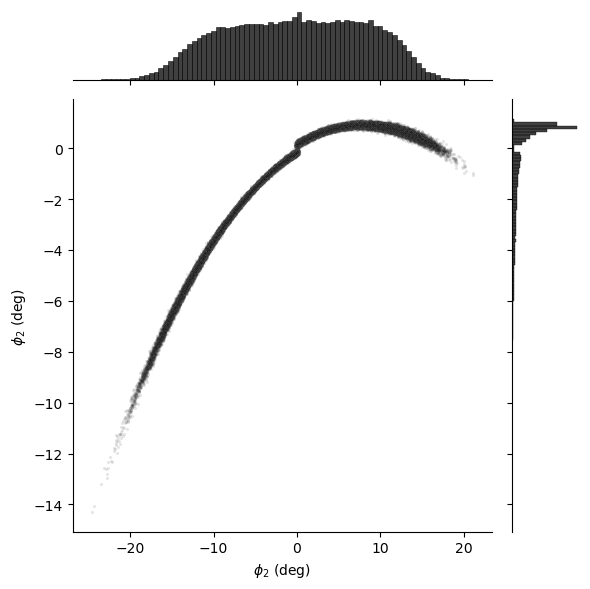

In [109]:
### plot the track in the radec frame to see how it would appears in the stream frame
# plt.figure()
# plt.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
# plt.scatter(phi12_s_trail.phi1, phi12_s_trail.phi2, s=0.5)
# plt.scatter(ra_prog, dec_prog, s=10)
# plt.xlabel("ra [deg]")
# plt.ylabel("dec [deg]")
# plt.title("Perturbed Stellar Stream")
# plt.show()

sns.jointplot(x=phi1_s, y=phi2_s, alpha=0.1,s=5, color='k')
# ax1.scatter(phi12_ps_trail.phi1, phi12_ps_trail.phi2, s=0.5)
plt.xlabel(r"$\phi_2$ (deg)")
plt.ylabel(r"$\phi_2$ (deg)")

plt.tight_layout()



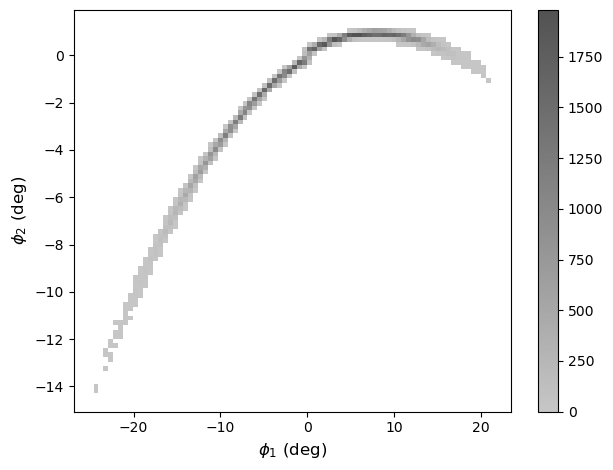

In [110]:
plt.figure()
hist2D = sns.histplot(x=phi1_s,y=phi2_s,bins=80, cbar=True, color='k')
plt.xlabel(r'$\phi_1$ (deg)',fontsize=12)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=12)
plt.tight_layout()


**Step 4: magnitude sampling**

Optional. Gives gri magnitude to stars, depending on isochrone properties and distance modulus. Same class as from stream_sim magnitude sampler



In [111]:
config = {
    "name": "Bressan2012",
    "survey": "lsst",
    "age": 12.0,
    "z": 0.0006,
    "band_1": "g",
    "band_2": "r",
    "band_1_detection": True
}
isochrone_model = sutils.IsochroneModel(config)

mag_g_s, mag_r_s = isochrone_model.sample_magnitudes(s_stars_icrs)

In [112]:
# Save stars table with sampled magnitudes
sutils.save_star_data(s_stars_icrs, mag_g_s, mag_r_s, 'radec', f"/home/hallouin/Documents/thall_2025/Streams/stream_sim/data/{cluster}_stars.csv")

Saved: /home/hallouin/Documents/thall_2025/Streams/stream_sim/data/Pal5_stars.csv


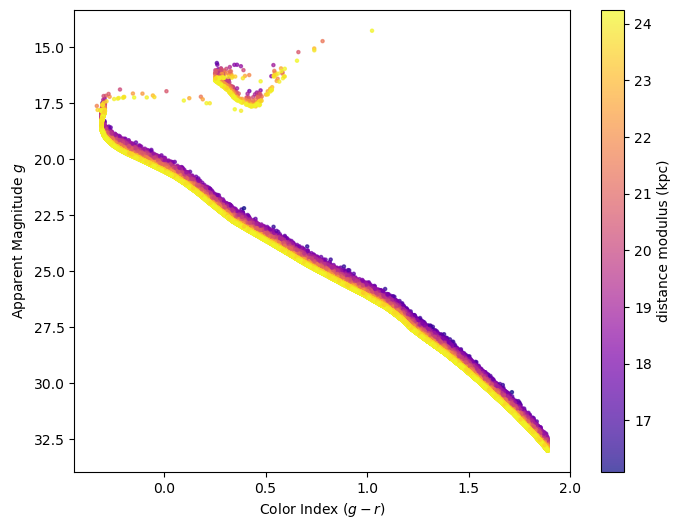

In [113]:
from astropy.table import Table

# Load the data
data_file = f"../data/{cluster}_stars.csv"  # Path to the saved CSV
table = Table.read(data_file, format="csv")

# Compute the color index (g-r)
color_index = table["mag_g"] - table["mag_r"]

# H-R diagram (Absolute mag vs. Color index)
plt.figure(figsize=(8, 6))
plt.scatter(color_index, table["mag_g"], s=5, c=table["dist"], cmap="plasma", alpha=0.7)

# Flip the y-axis (brighter stars at the top)
plt.gca().invert_yaxis()

# Labels
plt.xlabel(r"Color Index $(g - r)$")
plt.ylabel(r"Apparent Magnitude $g$")
# plt.title(f"H-R Diagram (Pal5, age = {12.0}, z = 0.0006)")

# Colorbar
plt.colorbar(label="distance modulus (kpc)")

# Show the plot
plt.show()


# Stellar stream Density

Now that we got star distribution along the stream, we are interested in computing the density along the track. To do so we define a function that count the number of star in a given box. The density is defined as follow: Phi1 increase linearly in the range [Phimin,Phimax]. To each interval [Phi1-deltaPhi1,Phi1+deltaPhi1] is assigned a mid track width value Phi2. It is sum the number of stars in the column of witdh w corresponding to Phi1[i], where w is the sum of each bin size in the Phi2 direction, i.e. the width of the track. final"density_table" is in the same format as the erkal.csv file from stream_sim 

In [168]:
mask= ((s_stars_phi12.phi1.value < -0.5) | (s_stars_phi12.phi1.value > 0.5)) & ((s_stars_phi12.phi1.value > -16) & (s_stars_phi12.phi1.value < 15))
# s_stars_phi12[(s_stars_phi12.phi1.value < -0.5) | (s_stars_phi12.phi1.value > -0.5)]

In [169]:
#Fitting the main track, 
#Phi1 from min/max/deltaphi1
#gaussian at Phi1[i], along phi2
#Phi2 from gaussian mu
#nstars from gaussian max
#width from gaussian std

stream_track_density = sutils.StreamInterpolateTrackDensity(s_stars_phi12[mask])
density_table = stream_track_density.compute_density(delta_phi1=0.02, phi2_bins=10) #same format as erkal (Phi1,Phi2,nstars,width)

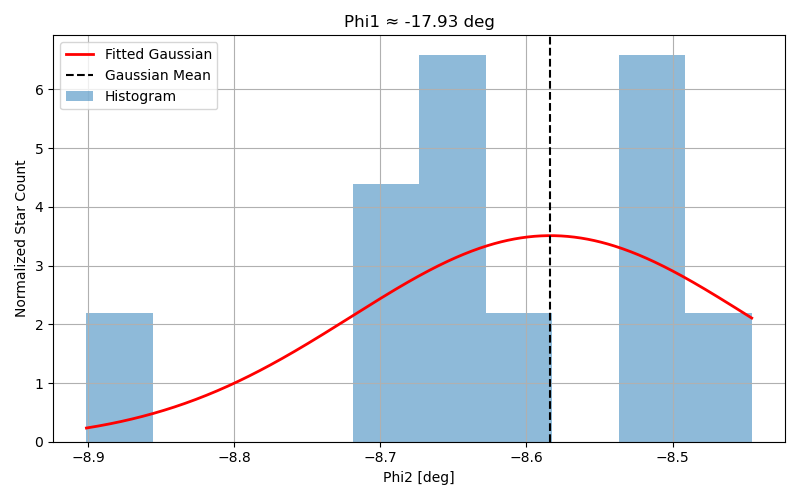

In [164]:
#Check if fit works
stream_track_density.plot_phi2_slice(phi1_target=-17.93, bins=10)

In [182]:
### Save data file to csv
# base_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
density_table.write(f'{base_dir}/data/hall_2024_{cluster}_input.csv', format='csv', overwrite=True)

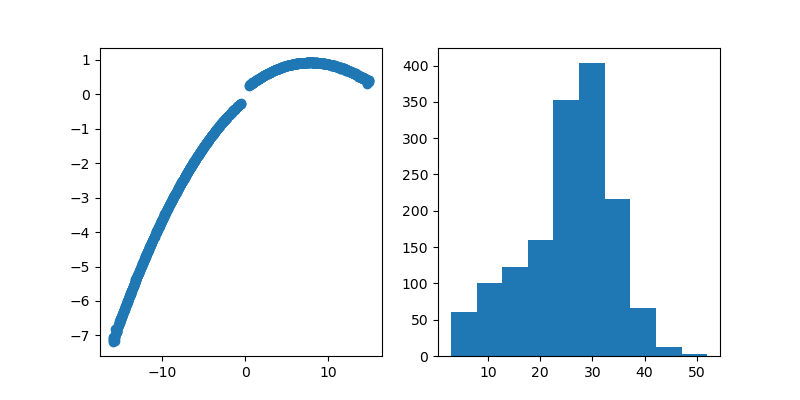

In [170]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(density_table['phi1'], density_table['phi2'])
plt.subplot(122)
plt.hist(density_table['nstars'])
plt.show()

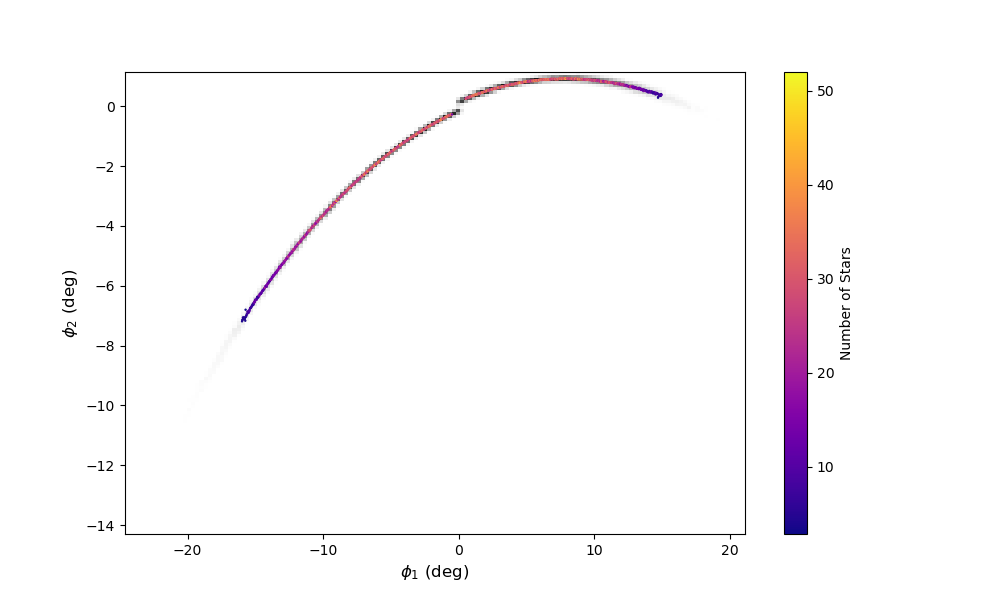

In [181]:
# Plot the density in the frame (scatter plot of phi1, phi2 values)
%matplotlib widget
plt.figure(figsize=(10, 6))
plt.hist2d(phi1_s.degree, phi2_s.degree, bins=[150, 150], cmap='binary')
plt.scatter(density_table['phi1'], density_table['phi2'], c=density_table['nstars'], cmap='plasma', s=0.5)
plt.colorbar(label='Number of Stars')
plt.xlabel(r'$\phi_1$ (deg)',fontsize=12)
plt.ylabel(r'$\phi_2$ (deg)',fontsize=12)
# plt.title('Star Density Along the Stream')
# plt.grid(True)
plt.show()

Second part is for true observed surfacic stellar density

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

def compute_stream_density(data, bin_width=0.1, plot=True):
    """
    Calcule la densité linéique projetée le long de Phi1.
    
    Parameters:
    - data (Astropy Table ou ndarray): avec colonnes ['Phi1', 'Phi2', 'dist'] ou équivalent
    - bin_width (float): largeur des bins en degrés
    - plot (bool): si True, trace le profil de densité

    Returns:
    - bin_centers (ndarray): centres des bins
    - densities (ndarray): densité surfacique (étoiles / degré)
    """
    
    # Adapter selon le type d'entrée
    if isinstance(data, Table):
        if "Phi1" in data.colnames:
            phi1 = np.array(data["Phi1"])
        else:
            raise ValueError("La table ne contient pas de colonne 'Phi1'.")
    elif isinstance(data, np.ndarray):
        if data.shape[1] >= 1:
            phi1 = data[:, 0]  # on suppose Phi1 en première colonne
        else:
            raise ValueError("Le tableau numpy n'a pas assez de colonnes (attendu: >=1).")
    else:
        raise TypeError("Entrée non supportée : utiliser Astropy Table ou numpy ndarray.")
    
    # Construction des bins
    phi1_min, phi1_max = np.min(phi1), np.max(phi1)
    bins = np.arange(phi1_min, phi1_max + bin_width, bin_width)
    
    # Histogramme
    counts, edges = np.histogram(phi1, bins=bins)
    bin_centers = 0.5 * (edges[1:] + edges[:-1])
    densities = counts / bin_width  # densité surfacique (étoiles / degré)
    densities /= np.mean(densities)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(bin_centers, densities, drawstyle='steps-mid')
        plt.xlabel("Phi1 (deg)")
        plt.ylabel("Densité (étoiles / deg)")
        plt.title("Densité le long du courant stellaire")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    return bin_centers, densities


In [25]:
def fit_polynomial_density(phi1_centers, densities_norm, degree=3, plot=True):
    """
    Adjust a polynom to a histogram
    params out: coeffs, poly_func
    """
    from numpy.polynomial.polynomial import Polynomial
    coeffs = Polynomial.fit(phi1_centers, densities_norm, degree).convert().coef
    poly_func = Polynomial(coeffs)

    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(phi1_centers, densities_norm, label="Normalized density per bin", drawstyle='steps-mid')
        plt.plot(phi1_centers, poly_func(phi1_centers), label=f"polymonial {degree}", color='red')
        plt.xlabel(r'$\phi_1$ (°)')
        plt.ylabel("Normalized density")
        plt.title("Perturbed stellar density along stream track")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return coeffs, poly_func

In [26]:
#Compute normalized density
centers, dens_norm_unperturbed = compute_stream_density(stream_phi12_lead, bin_width=0.1, plot=False)
centers, dens_norm_perturbed = compute_stream_density(stream_phi12_perturbed, bin_width=0.1, plot=False)

#adjust polynom
coeffs_unperturbed, poly_model_unperturbed = fit_polynomial_density(centers, dens_norm_unperturbed, degree=6)
coeffs_perturbed, poly_model_perturbed = fit_polynomial_density(centers, dens_norm_perturbed, degree=6)


NameError: name 'stream_phi12_lead' is not defined

In [ ]:
plt.figure(figsize=(8, 4))
# plt.plot(centers, (dens_norm_perturbed-dens_norm_unperturbed)/dens_norm_unperturbed, drawstyle='steps-mid')
plt.plot(centers, (poly_model_perturbed(centers)-poly_model_unperturbed(centers))/poly_model_unperturbed(centers), color='red')
plt.xlabel(r'$\phi_1$ (°)')
plt.ylabel(r'$\delta(\phi_1)$')
plt.title("Relative stellar density difference along stream track")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
